In [1]:
import json
import os
import sys

import numpy as np
import torch
import ubjson
from matplotlib import pyplot as plt

sys.path.insert(0, os.path.abspath('..'))
from xgbackprop.xgbackprop import FlatXGBackpropLayer

torch.cuda.is_available()

/Users/randyardywibowo/miniconda3/envs/core/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


False

In [2]:
# load model from file
model_name = '/Users/randyardywibowo/Github/xgbackprop/models/model.json'
with open(model_name, "r") as fd:
    model = json.load(fd)

device = 'cuda'
model = FlatXGBackpropLayer(model)

In [3]:
from numpy import loadtxt

# load data
dataset = loadtxt('../data/pima-indians-diabetes.csv', delimiter=",")

# split data into X and y
X = dataset[:, 0:8]
Y = dataset[:, 8]

In [5]:
x_tensor = torch.Tensor(X[:10, :])
# x_tensor = x_tensor[None, :]

model.train()
model(x_tensor)

tensor([1639.1926, 1720.6111, 1143.3629, 2095.1338, 3375.3989,  465.5726,
        1079.0725,  493.2894, 2308.6367,  696.5468])

In [6]:
model.eval()
model(x_tensor)

tensor([ 9.9948e-01,  3.5827e-03,  1.7496e-01, -1.1397e-02,  1.5341e+03,
        -2.6250e-04,  9.9498e-01,  4.6560e-04,  9.9978e-01,  1.0009e-02])

In [7]:
import xgboost as xgb

model = xgb.Booster()
model.load_model(model_name)
# model.get_dump(dump_format='json')
x_matrix = xgb.DMatrix(X)
preds = model.predict(x_matrix)
pred_leaf = model.predict(x_matrix, pred_leaf=True)
preds


array([ 9.99478579e-01,  3.58263683e-03,  1.92080036e-01, -1.13972947e-02,
        1.00033498e+00, -2.62531510e-04,  9.94977534e-01,  4.65604360e-04,
        9.99782026e-01,  1.08163487e-02, -4.17266769e-04,  1.00002718e+00,
       -9.22115069e-05,  8.50570917e-01,  9.99904037e-01,  9.97862875e-01,
        1.00017178e+00,  5.47448516e-01, -1.28104381e-04,  9.97921050e-01,
        2.33660438e-04,  5.45085233e-04,  9.62345064e-01,  9.99834955e-01,
        5.07359385e-01,  2.43873417e-01,  9.97956812e-01, -4.39918404e-05,
        2.53257662e-04,  2.42125685e-03,  2.93858722e-03,  1.00016093e+00,
       -1.32402551e-04, -2.81628803e-04,  8.19959521e-01,  4.25250444e-04,
        1.60869572e-03,  9.98246133e-01,  9.95543957e-01,  1.00016081e+00,
        1.35858741e-03,  7.73274631e-04, -8.04867959e-05,  9.99829412e-01,
        7.17188464e-04,  9.99697983e-01,  7.99839497e-01, -4.49713145e-04,
        7.71562994e-01,  1.17299135e-03,  1.09131476e-02,  3.44842486e-02,
        4.99318587e-03,  

In [33]:
with open('/Users/randyardywibowo/Github/xgbackprop/models/model.json', "r") as fd:
    json_model = json.load(fd)

j_trees = json_model["learner"]["gradient_booster"]["model"]["trees"]

In [53]:
# list(pred_leaf.astype(int).flatten())

In [55]:
np.array([j_trees[i]["loss_changes"][leaf] for i, leaf in enumerate(list(pred_leaf.astype(int).flatten()))]).sum()

0.000229760666976

In [5]:
model.train()
# model = torch.jit.script(model)
# model = torch.compile(model)
input = torch.nn.Embedding(1, 8)
optimizer = torch.optim.Adam(list(model.parameters()) + list(input.parameters()))

In [6]:
outputs = []

In [8]:
for i in range(50):
    encoder_output = input(torch.tensor([0]))
    output = model(encoder_output)
    loss = torch.nn.MSELoss()(output, torch.tensor([1.]))
    outputs.append(output.detach().numpy())
    
    if (i // 100) % 2 != 0:
        print("Target: -10")
    else:
        print("Target: +10")
        loss = torch.square(output - 1)
        outputs.append(output.detach().numpy())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10
Target: +10


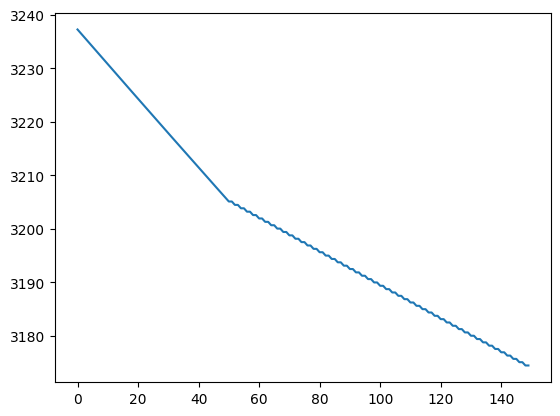

In [9]:
plt.plot(outputs)

In [13]:
len(outputs)

3